In [1]:
import sys 
sys.path.append('../lznestpy')

import nestpy
from random import choices
from nestUtils import *

import matplotlib.pyplot as plt
import numpy as np

from LXeSimulation import *
from LArSimulation import *

import numpy as np

nEvents = 1000000

In [2]:
def calculateSignalSignificance(eventRateFile, bkgRateFiles, exposure):
    # Simulate observed events and background events
    
    nPrimarySig, nRecombinationSig, nObservedSig, energiesSig, weightSig = simulate_LAr_Primary(eventRateFile, nEvents)
    histObserved, edges = np.histogram(nObservedSig, bins=np.arange(0, 100), weights=weightSig)
    totalSignal = np.trapz(histObserved[3:50], edges[3:50])

    totalBkg = 0
    for bkgRateFile in bkgRateFiles:
        BKGArray = np.loadtxt(bkgRateFile,  skiprows=1,delimiter=',')
        nElectrons, nBkgEvents = BKGArray[:,0], BKGArray[:,1]*365.25*1000
        totalBkg += np.trapz(nBkgEvents, nElectrons)


    return (totalSignal / np.sqrt(totalBkg)) * np.sqrt(exposure), histObserved, nBkgEvents, nElectrons, edges[1:]



Total rate is:  0.0021326134241850363
0.0020378923326408336


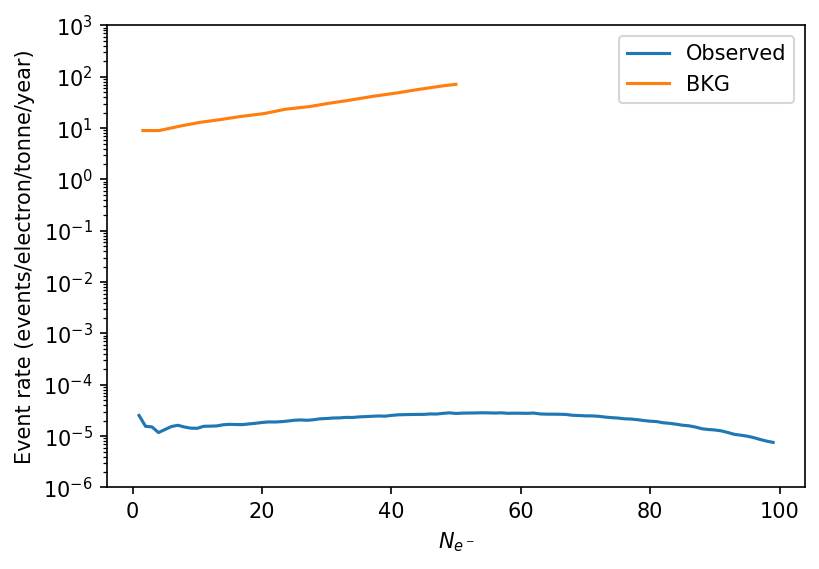

In [4]:
SS, histObserved, nBkgEvents, nElectrons, edges = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50pTable.csv", 
    ["/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt",
     "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_agressive_DSLM_afterCut.txt"], 
    1.0)

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(edges, histObserved, label='Observed')
ax.plot(nElectrons, nBkgEvents, label='BKG')

print(np.trapz(histObserved[0:100], edges[0:100]))

ax.set_xlabel(r'$N_{e^-}$')
ax.set_ylabel('Event rate (events/electron/tonne/year)')
ax.set_yscale('log')
ax.legend()
ax.set_ylim(1e-6, 1e3)
plt.show()


In [5]:
import os as os

ArgoSignificanceTable = []

ArgoEventRateFiles = sorted(os.listdir("/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon_ScaleGx"))

for ArgoEventRateFile in ArgoEventRateFiles:
    significance_current = calculateSignalSignificance(f"/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon_ScaleGx/{ArgoEventRateFile}",
                                                        ["/Users/yxu/workbenches/XeArLoopworkbench/Gamma_DSLM_afterCut.txt",
                                                         "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_agressive_DSLM_afterCut.txt"], 
                                                        1.0)    
    ArgoSignificanceTable.append(significance_current[0])
    print(ArgoEventRateFile, significance_current[0])


Ar10pMaxGxTable.csv 296.54705269441365
Ar10pMinGxTable.csv 7.130423305401869e-09
Ar10pNormalGxTable.csv 7.1300525278242e-05
Ar10plMaxGxTable.csv 0.7192949134592597
Ar10plMinGxTable.csv 1.3979220459141151e-05
Ar10plNormalGxTable.csv 0.0001462659659081732
Ar10zMaxGxTable.csv 11.737415639048912
Ar10zMinGxTable.csv 1.1725017455464659e-07
Ar10zNormalGxTable.csv 0.0011716649219310712
Ar10zlMaxGxTable.csv 11.86895718931049
Ar10zlMinGxTable.csv 0.0004187470111691698
Ar10zlNormalGxTable.csv 0.002955026868725543
Ar50pMaxGxTable.csv 0.018654883405087464
Ar50pMinGxTable.csv 1.8646432333302262e-10
Ar50pNormalGxTable.csv 1.8646525887608354e-06
Ar50plMaxGxTable.csv 0.018754309271111075
Ar50plMinGxTable.csv 3.9713360046638766e-07
Ar50plNormalGxTable.csv 3.92638858723318e-06
Ar50zMaxGxTable.csv 14.139315101831993
Ar50zMinGxTable.csv 1.4105938629768723e-07
Ar50zNormalGxTable.csv 0.0014208624541694364
Ar50zlMaxGxTable.csv 14.272355900333688
Ar50zlMinGxTable.csv 0.0004229520941420509
Ar50zlNormalGxTable.c

In [8]:
def parse_argon_filename_auto(filename):
    """
    Parse Argon filename to extract model parameters
    Format example: mpi7_PS-PS_mchi10_gchi0.6_cHiggs0_EventRate
    
    Returns:
        mphi: Mediator mass in GeV (float)
        is_ps_ps: Whether interaction type is PS-PS (bool)
        mchi: DM mass in GeV (float) 
        gchi: DM coupling (float)
        c_higgs: Higgs coupling (float)
    """
    import re
    
    # Extract mphi
    mphi = float(re.search(r'mpi(\d+(?:\.\d+)?)', filename).group(1))
    
    # Check if PS-PS exists
    is_ps_ps = 'PS-PS' in filename
    
    # Extract mchi
    mchi = float(re.search(r'mchi(\d+(?:\.\d+)?)', filename).group(1))
    
    # Extract gchi
    gchi = float(re.search(r'gchi(\d+(?:\.\d+)?)', filename).group(1))
    
    # Extract cHiggs
    c_higgs = float(re.search(r'cHiggs(\d+(?:\.\d+)?)', filename).group(1))
    
    return mphi, is_ps_ps, mchi, gchi, c_higgs

print(parse_argon_filename_auto("mpi7_PS-PS_mchi10_gchi0.6_cHiggs0_EventRate.csv"))

ArgonEventRateFolder = "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon_auto"
ArgoEventRateFiles = sorted(os.listdir(ArgonEventRateFolder))
DMLMExposure = 1.0

mphi_table = []
is_ps_ps_table = []
mchi_table = []
gchi_table = []
c_higgs_table = []
significance_table = []

for ArgoEventRateFile in ArgoEventRateFiles:
    mphi, is_ps_ps, mchi, gchi, c_higgs = parse_argon_filename_auto(ArgoEventRateFile)
    significance_current = calculateSignalSignificance(f"{ArgonEventRateFolder}/{ArgoEventRateFile}",
                                                        ["/Users/yxu/workbenches/XeArLoopworkbench/Gamma_DSLM_afterCut.txt",
                                                         "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_agressive_DSLM_afterCut.txt"], 
                                                        DMLMExposure)    
    mphi_table.append(mphi)
    is_ps_ps_table.append(is_ps_ps)
    mchi_table.append(mchi)
    gchi_table.append(gchi)
    c_higgs_table.append(c_higgs)
    significance_table.append(significance_current[0])




(7.0, True, 10.0, 0.6, 0.0)


In [9]:
# Create DataFrame from tables
import pandas as pd

df = pd.DataFrame({
    'mphi[GeV]': mphi_table,
    'is_ps_ps': is_ps_ps_table, 
    'mchi[GeV]': mchi_table,
    'gchi': gchi_table,
    'c_higgs': c_higgs_table,
    'significance_full_exposure': significance_table,
    'significance_unit_exposure [1/tonne^(0.5)/year^(0.5)]': significance_table
})

# Save to CSV
df.to_csv('argon_auto_results_unit_exposure.csv', index=False)


In [15]:
def parse_argon_filename(filename):
    """
    Parse Argon filename to extract model parameters
    Format example: ArNNTable.csv, ArNNlTable.csv, ArNNpTable.csv, ArNNzTable.csv
    where NN is DM mass number
    
    Returns:
        dm_mass: DM mass in GeV
        med_mass: Mediator mass (7 GeV if 'Light' in name, else 15 GeV) 
        interaction: Interaction type ('S-PS' if 'p' in name, 'PS-PS' if 'z' in name)
        has_higgs: Boolean indicating if model has Higgs coupling ('l' before Table)
    """
    import re
    dm_mass = float(re.search(r'Ar(\d+)', filename).group(1))
    
    med_mass = 7 if 'Light' in filename else 15
    
    if 'p' in filename:
        interaction = 'PS-PS'
    elif 'z' in filename:
        interaction = 'S-PS'
    else:
        interaction = None

    if 'Normal' in filename:
        gSM = 1
    elif 'Max' in filename:
        gSM = 6
    else:
        gSM = 0.6
        
    has_higgs = bool(re.search(r'l(?=Table)', filename))
    
    return dm_mass, med_mass, interaction, has_higgs, gSM

# Parse Argon data
dmMassTable = []
medMassTable = []
interactionTable = []
hasHiggsTable = []
for filename, signalSignificance in zip(ArgoEventRateFiles, ArgoSignificanceTable):
    dm_mass, med_mass, interaction, has_higgs = parse_argon_filename(filename)
    dmMassTable.append(dm_mass)
    medMassTable.append(med_mass)
    interactionTable.append(interaction)
    hasHiggsTable.append(has_higgs)

# Create pretty tables
from prettytable import PrettyTable
import math

# Table for S-PS interaction
table_sps = PrettyTable()
table_sps.field_names = ["DM Mass (GeV)", "Mediator Mass (GeV)", "Higgs Coupling", "log10(Significance)"]
table_sps.title = "LAr PS-PS Interaction, gSM = 0.6, gDM = 0.7"

# Table for PS-PS interaction 
table_psps = PrettyTable()
table_psps.field_names = ["DM Mass (GeV)", "Mediator Mass (GeV)", "Higgs Coupling", "log10(Significance)"]
table_psps.title = "LAr S-PS Interaction, gSM = 0.6, gDM = 0.7"

# Sort data into tables
for dm, med, inter, higgs, sig in zip(dmMassTable, medMassTable, interactionTable, hasHiggsTable, ArgoSignificanceTable):
    if inter == 'PS-PS':
        table_sps.add_row([dm, med, higgs, f"{math.log10(sig):.2f}"])
    elif inter == 'S-PS':
        table_psps.add_row([dm, med, higgs, f"{math.log10(sig):.2f}"])

print(table_sps)
print("\n")
print(table_psps)


+----------------------------------------------------------------------------+
|                LAr PS-PS Interaction, gSM = 0.6, gDM = 0.7                 |
+---------------+---------------------+----------------+---------------------+
| DM Mass (GeV) | Mediator Mass (GeV) | Higgs Coupling | log10(Significance) |
+---------------+---------------------+----------------+---------------------+
|      10.0     |          7          |     False      |        -3.87        |
|      10.0     |          7          |      True      |        -3.63        |
|      10.0     |          15         |     False      |        -4.73        |
|      10.0     |          15         |      True      |        -4.49        |
|     200.0     |          7          |     False      |        -5.47        |
|     200.0     |          7          |      True      |        -5.22        |
|     200.0     |          15         |     False      |        -5.76        |
|     200.0     |          15         |      True   

In [41]:
SS_Ar200p, histObserved_Ar200p, nBkgEvents_Ar200p, nElectrons_Ar200p, edges_Ar200p = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200pTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar200pl, histObserved_Ar200pl, nBkgEvents_Ar200pl, nElectrons_Ar200pl, edges_Ar200pl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200plTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar200z, histObserved_Ar200z, nBkgEvents_Ar200z, nElectrons_Ar200z, edges_Ar200z = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200zTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar200zl, histObserved_Ar200zl, nBkgEvents_Ar200zl, nElectrons_Ar200zl, edges_Ar200zl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200zlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)


SS_Ar50p, histObserved_Ar50p, nBkgEvents_Ar50p, nElectrons_Ar50p, edges_Ar50p = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50pTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar50pl, histObserved_Ar50pl, nBkgEvents_Ar50pl, nElectrons_Ar50pl, edges_Ar50pl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50plTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar50z, histObserved_Ar50z, nBkgEvents_Ar50z, nElectrons_Ar50z, edges_Ar50z = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50zTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar50zl, histObserved_Ar50zl, nBkgEvents_Ar50zl, nElectrons_Ar50zl, edges_Ar50zl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50zlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar10p, histObserved_Ar10p, nBkgEvents_Ar10p, nElectrons_Ar10p, edges_Ar10p = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10pTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar10pl, histObserved_Ar10pl, nBkgEvents_Ar10pl, nElectrons_Ar10pl, edges_Ar10pl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10plTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar10z, histObserved_Ar10z, nBkgEvents_Ar10z, nElectrons_Ar10z, edges_Ar10z = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10zTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_Ar10zl, histObserved_Ar10zl, nBkgEvents_Ar10zl, nElectrons_Ar10zl, edges_Ar10zl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10zlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)





(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)


In [42]:
SS_ArLight200p, histObserved_ArLight200p, nBkgEvents_ArLight200p, nElectrons_ArLight200p, edges_ArLight200p = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200LightpTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight200pl, histObserved_ArLight200pl, nBkgEvents_ArLight200pl, nElectrons_ArLight200pl, edges_ArLight200pl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200LightplTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight200z, histObserved_ArLight200z, nBkgEvents_ArLight200z, nElectrons_ArLight200z, edges_ArLight200z = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200LightzTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight200zl, histObserved_ArLight200zl, nBkgEvents_ArLight200zl, nElectrons_ArLight200zl, edges_ArLight200zl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar200LightzlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight50p, histObserved_ArLight50p, nBkgEvents_ArLight50p, nElectrons_ArLight50p, edges_ArLight50p = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50LightpTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight50pl, histObserved_ArLight50pl, nBkgEvents_ArLight50pl, nElectrons_ArLight50pl, edges_ArLight50pl = calculateSignalSignificance(
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50LightplTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight50z, histObserved_ArLight50z, nBkgEvents_ArLight50z, nElectrons_ArLight50z, edges_ArLight50z = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50LightzTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight50zl, histObserved_ArLight50zl, nBkgEvents_ArLight50zl, nElectrons_ArLight50zl, edges_ArLight50zl = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar50LightzlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight10p, histObserved_ArLight10p, nBkgEvents_ArLight10p, nElectrons_ArLight10p, edges_ArLight10p = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10LightpTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight10pl, histObserved_ArLight10pl, nBkgEvents_ArLight10pl, nElectrons_ArLight10pl, edges_ArLight10pl = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10LightplTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight10z, histObserved_ArLight10z, nBkgEvents_ArLight10z, nElectrons_ArLight10z, edges_ArLight10z = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10LightzTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)

SS_ArLight10zl, histObserved_ArLight10zl, nBkgEvents_ArLight10zl, nElectrons_ArLight10zl, edges_ArLight10zl = calculateSignalSignificance(   
    "/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Argon/Ar10LightzlTable.csv", 
    "/Users/yxu/workbenches/XeArLoopworkbench/Ar39_conservative_DSLM_afterCut.txt", 
    1.0)







(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
(9,) (9,)
(99,) (100,)
